# Walmart Trip Type Classification
Brought to you by Shaun J

## Preparation and Overview

### Business Understanding

Walmart strives for making better understanding and services to their customers consistently from both artistic and scientific approach. One of their methods to make such effort is to segment the store into different sections according to possible trip types, in order to improve shopping experiences for its customers.
 
Walmart believes that this is the best shopping experience for every customer, because the customers can access their demands regardless of leisurely going through their shopping lists or a short trip for instant needs. The company has started combining the existing customer insights and the purchase history data to decide the trip types for the customers. Because such project is meant to optimize the isle placement in store and not to predict what the customers would buy, there is no real-time data employment needed in the model, which means there is no deployment and our model is for offline analysis only.
 
I intend to upgrade such project, which aims to focus on the classifying customer trips using only a transactional dataset of the items purchased by the customers recently. I will be improving the science behind trip type, and the classification of trip type will help Walmart refine its classic segmentation process. Consequently, the items will be placed in the area in accordance to the trip type with which it is most attached.
 
### Data Understanding
Here is a list of the data features contained in our dataset.
 
1) TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.
 
2) VisitNumber - an id corresponding to a single trip by a single customer
 
3) Weekday - the weekday of the trip

4) Upc - the UPC number of the product purchased
 
5) ScanCount - the number of the given item that was purchased. A negative value indicates a product return.
 
6) DepartmentDescription - a high-level description of the item's department
 
7) FinelineNumber - a more refined category for each of the products, created by Walmart
 
The trip types have been categorized into 38 distinct types using a proprietary method applied to an extended set of data. I intend to recreate this categorization/clustering with optimization and logistic regression algorithms, and each customer would be given exactly one trip type prediction. I believe these methods could provide new and more robust ways to categorize trips, and then helping to improve customer shopping experiences at Walmart.
 
### References:
https://www.kaggle.com/c/walmart-recruiting-trip-type-classification

In [1]:
#import statements
import pandas as pd
import numpy as np
import re 
import warnings
warnings.filterwarnings(action="ignore")

from zipfile import ZipFile
from sklearn import svm, tree
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, log_loss,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import seaborn as sns


from matplotlib import pyplot as plt
%matplotlib inline

base_color = sns.color_palette()[0]

IPython (Interactive Python) is a command shell for interactive computing in multiple programming languages, originally developed for the Python programming language, that offers introspection, rich media, shell syntax, tab completion, and history. IPython provides the following features:

IPython(交互式Python)是一个命令shell交互计算多种编程语言,最初为Python编程语言开发,提供内省,富媒体,shell语法,选项卡完成,和历史。IPython提供了以下特性:

* Interactive shells (terminal and Qt-based).
* A browser-based notebook interface with support for code, text, mathematical expressions, inline plots and other media.
* Support for interactive data visualization and use of GUI toolkits.
* Flexible, embeddable interpreters to load into one's own projects.
* Tools for parallel computing.

* 交互式shell(基于终端和qt)。
* 一个基于浏览器的笔记本界面，支持代码、文本、数学表达式、内联绘图和其他媒体。
* 支持交互式数据可视化和使用GUI工具包。
* 灵活，可嵌入的解释器加载到自己的项目。
* 并行计算工具。

##### Plotting from an IPython notebook
The IPython notebook is a browser-based interactive data analysis tool that can combine narrative, code, graphics, HTML elements, and much more into a single executable document (see [IPython: Beyond Normal Python](https://jakevdp.github.io/PythonDataScienceHandbook/01.00-ipython-beyond-normal-python.html)).

IPython notebook是一种基于浏览器的交互式数据分析工具，可以将叙事、代码、图形、HTML元素以及更多内容组合到一个单独的可执行文档中(参见IPython: Beyond Normal Python)。

Plotting interactively within an IPython notebook can be done with the `%matplotlib` command, and works in a similar way to the IPython shell. In the IPython notebook, you also have the option of embedding graphics directly in the notebook, with two possible options:

可以使用 `%matplotlib` 命令在IPython记事本中进行交互式绘图，其工作方式与IPython shell类似。在IPython笔记本中，您还可以选择直接在笔记本中嵌入图形，有两种可能的选项:

* `%matplotlib notebook` will lead to interactive plots embedded within the notebook
* `%matplotlib notebook` 将导致嵌入在notebook中的交互式情节
* `%matplotlib inline` will lead to static images of your plot embedded in the notebook
* `%matplotlib inline` 将导致您的绘图静态图像嵌入笔记本

Here we generally opt for `%matplotlib inline`:
```
%matplotlib inline
```
After running this command (it needs to be done only once per kernel/session), any cell within the notebook that creates a plot will embed a PNG image of the resulting graphic.

运行此命令后(每个内核/会话只需要执行一次)，创建绘图的笔记本中的任何单元都将嵌入生成图形的PNG图像。

In [2]:
# use ZipFile() and .open() to load and preview training data
with ZipFile("train.zip") as zf: 
    with zf.open("train.csv") as f: 
        df = pd.read_csv(f)
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [3]:
# use .info() to show basic DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               647054 non-null  int64  
 1   VisitNumber            647054 non-null  int64  
 2   Weekday                647054 non-null  object 
 3   Upc                    642925 non-null  float64
 4   ScanCount              647054 non-null  int64  
 5   DepartmentDescription  645693 non-null  object 
 6   FinelineNumber         642925 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [4]:
# use .copy() get a copy of the original data and edit this copy forward
df_copy=df.copy()

# use .isnull(), .sum() and .shape to find missing values and their proportion in original data
print(df_copy.isnull().sum(), '\n')
print(df_copy.isnull().sum()/df.shape[0], '\n')

# what are the .unique() departments available in this dataset?

print(df_copy['DepartmentDescription'].unique(), '\n')

# did you find a problem in the department names? if so, fix the wrong department names
# df_copy= df_copy.replace(' ', '_', regex=True)

df_copy = df_copy.replace("MENS WEAR", "MENSWEAR")

# are upc and FinelineNumber always missing together?
upc_null = df_copy.Upc.isnull()
print(df_copy.FinelineNumber[upc_null].isnull() * 100,
      '% of UPC and %d FinelineNumber values are missing together.')
# '{:.0%f}'.format()
# what are the departments when upc/FinelineNumber are missing?
#print("Departments of missing items:", , '\n')
#.unique()

# when dept is missing, are both upc and FinelineNumber missing? (only need to test one of upc and FinelineNumber)
print('% of Department and UPC/FinelineNumber values are missing together.' %(df_copy['DepartmentDescription'].isna().sum()))

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64 

TripType                 0.000000
VisitNumber              0.000000
Weekday                  0.000000
Upc                      0.006381
ScanCount                0.000000
DepartmentDescription    0.002103
FinelineNumber           0.006381
dtype: float64 

['FINANCIAL SERVICES' 'SHOES' 'PERSONAL CARE' 'PAINT AND ACCESSORIES'
 'DSD GROCERY' 'MEAT - FRESH & FROZEN' 'DAIRY' 'PETS AND SUPPLIES'
 'HOUSEHOLD CHEMICALS/SUPP' nan 'IMPULSE MERCHANDISE' 'PRODUCE'
 'CANDY, TOBACCO, COOKIES' 'GROCERY DRY GOODS' 'BOYS WEAR'
 'FABRICS AND CRAFTS' 'JEWELRY AND SUNGLASSES' 'MENS WEAR' 'ACCESSORIES'
 'HOME MANAGEMENT' 'FROZEN FOODS' 'SERVICE DELI'
 'INFANT CONSUMABLE HARDLINES' 'PRE PACKED DELI' 'COOK AND DINE'
 'PHARMACY OTC' 'LADIESWEAR' 'COMM BREAD' 'BAKERY' 'HOUSEHOLD PAPER GOODS

In [5]:
# use .dropna() to drop NA values
df_copy=df_copy.dropna()

In [6]:
# use .info() to check basic DataFrame info after .dropna()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642925 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               642925 non-null  int64  
 1   VisitNumber            642925 non-null  int64  
 2   Weekday                642925 non-null  object 
 3   Upc                    642925 non-null  float64
 4   ScanCount              642925 non-null  int64  
 5   DepartmentDescription  642925 non-null  object 
 6   FinelineNumber         642925 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.2+ MB


Our data set, in its original form, contains 7 features and 647,054 observations. The features are as follows:

TripType: Each distinct value represents a unique trip type, i.e., the set of circumstances that underlie the customer's trip to a Walmart store. Trip Types could include anything from "weekly grocery trip" to "buying bread (or dinner) on the way home from work." The values in this column are integers, and we don't have a key mapping each integer to a trip rationale, so we will have to work with them without knowing what the numbers actually mean. Although the values are stored as integers, this is a discrete/categorical variable, and it is also our target variable.

VisitNumber: Each distinct value represents a single trip by a Walmart shopper. This is our identifier variable for the dataset we will actually use to train the logistic regression classifier and predict values of TripType. That is, our final dataset will have a number of rows equal to the number of unique values in this column where the TripType is one we choose to predict. (More on that last part in a bit).

Weekday: The day of the week on which the trip to Walmart was made. There are 7 unique values of this variable because this is Walmart, not Chick-fil-a.

Upc: This feature contains the UPC barcode number that identifies products sold in stores. The number consists of a manufacturer number and a product code, as well as an extra digit calculated from the other digits used for inventory management purposes and to protect against data entry (human) errors. This variable contains a plethora of information, but will ultimately be dropped, as we explain later.

ScanCount: The number of a particular item that a customer purchased. For example, 3 represents that the customer bought 3 of whatever item is represented by the value in the Upc column.

Department Description: Walmart breaks its stores up into a number of departments which are mutually exclusive. That is, those products which fall into one department fall into only that department. This variable is a string representing that department.

FinelineNumber: This is a numeric value representing a "product category," a Walmart-created system that places products into more narrow groups than in the Department Description feature.

In [7]:
# use .set_options() to show all columns in a data frame
pd.set_option('display.max_columns', None)
print(df_copy)


# use pd.crosstab() to make a sample data showing the relationship between Trip Types and Depts
pd.crosstab(df_copy.TripType, df_copy.DepartmentDescription)

        TripType  VisitNumber Weekday           Upc  ScanCount  \
0            999            5  Friday  6.811315e+10         -1   
1             30            7  Friday  6.053882e+10          1   
2             30            7  Friday  7.410811e+09          1   
3             26            8  Friday  2.238404e+09          2   
4             26            8  Friday  2.006614e+09          2   
...          ...          ...     ...           ...        ...   
647049        39       191346  Sunday  3.239000e+10          1   
647050        39       191346  Sunday  7.874205e+09          1   
647051        39       191346  Sunday  4.072000e+03          1   
647052         8       191347  Sunday  4.190008e+09          1   
647053         8       191347  Sunday  3.800060e+09          1   

        DepartmentDescription  FinelineNumber  
0          FINANCIAL SERVICES          1000.0  
1                       SHOES          8931.0  
2               PERSONAL CARE          4504.0  
3       PAINT A

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PHARMACY RX,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
TripType,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,2,2,20,5,8,24,4,4,9,0,5,24,17,4,2,12,13,59,15,7,5369,7,1,2,11,11,0,2,14,0,5,5,804,1,11,10,0,4,76,9,9,1,10,40,12,1,0,0,3,40,11,45,0,1,1,0,22,0,0,13,0,6,2,16,2,6,3
4,0,1,3,13,0,7,0,0,0,0,0,9,3,8,0,1,11,73,0,0,5,6,0,1,18,1,0,2,3,4,5,13,47,0,0,1,0,0,0,0,0,1,0,7,2,0,0,0,1,32,2,563,0,0,0,2,37,0,0,9,0,1,0,2,0,2,0
5,1,16,40,66,25,232,7,15,15,9,2,133,83,94,0,54,237,614,18,61,50,114,0,13,384,46,0,37,64,16,142,114,519,9,29,24,15,36,0,60,36,21,15,78,83,396,85,0,10,922,95,5281,144,0,1,25,435,3,1,97,6,40,16,39,0,19,11
6,1,3,5,23,6,23,2,2,1,0,0,674,30,32,0,14,92,360,2,11,14,84,0,1,154,8,0,5,11,4,59,55,227,2,2,2,0,12,0,14,1000,25,3,9,14,0,0,1,1,73,26,51,0,0,0,25,148,4,1,56,0,13,4,9,0,3,1
7,3,11,31,897,5,75,8,15,6,2,0,151,44,1341,0,62,1273,2097,12,26,65,2278,1,12,3354,37,0,24,24,13,217,242,606,7,49,13,3,31,0,54,71,1527,7,46,41,3,0,1,12,206,45,159,0,3,2,826,3022,330,0,3669,4,29,12,30,3,20,11
8,0,6,56,472,36,1112,6,17,16,6,0,579,101,476,0,47,1813,4747,11,38,0,433,0,16,1532,54,0,22,59,10,974,705,2488,16,361,26,4,34,0,24,49,24,5,34,84,3,0,0,24,2650,552,648,0,1,2,61,1974,2,0,218,3,50,9,31,9,28,8
9,80,186,889,61,223,164,130,101,273,165,69,119,719,54,0,412,133,550,521,343,61,51,23,172,126,616,0,278,459,199,105,80,1354,174,180,452,65,662,0,440,10,7,247,1434,709,2,0,1,199,343,39,219,0,98,32,11,186,0,1,70,57,636,177,661,55,573,282
12,0,0,4,16,14,18,1,1,3,2,0,15,24,91,0,32,92,278,6,2,7,22,0,7,231,9,0,2,9,0,53,278,83,6,7,1,0,7,0,269,12,69,1,6,17,1,0,0,9,56,10,38,0,0,0,52,121,5,1,17,0,13,2,17,2,65,0
14,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,15,2,0,0,0,0,0,0,0,0,0,0,1,6,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='TripType', ylabel='DepartmentDescription'>

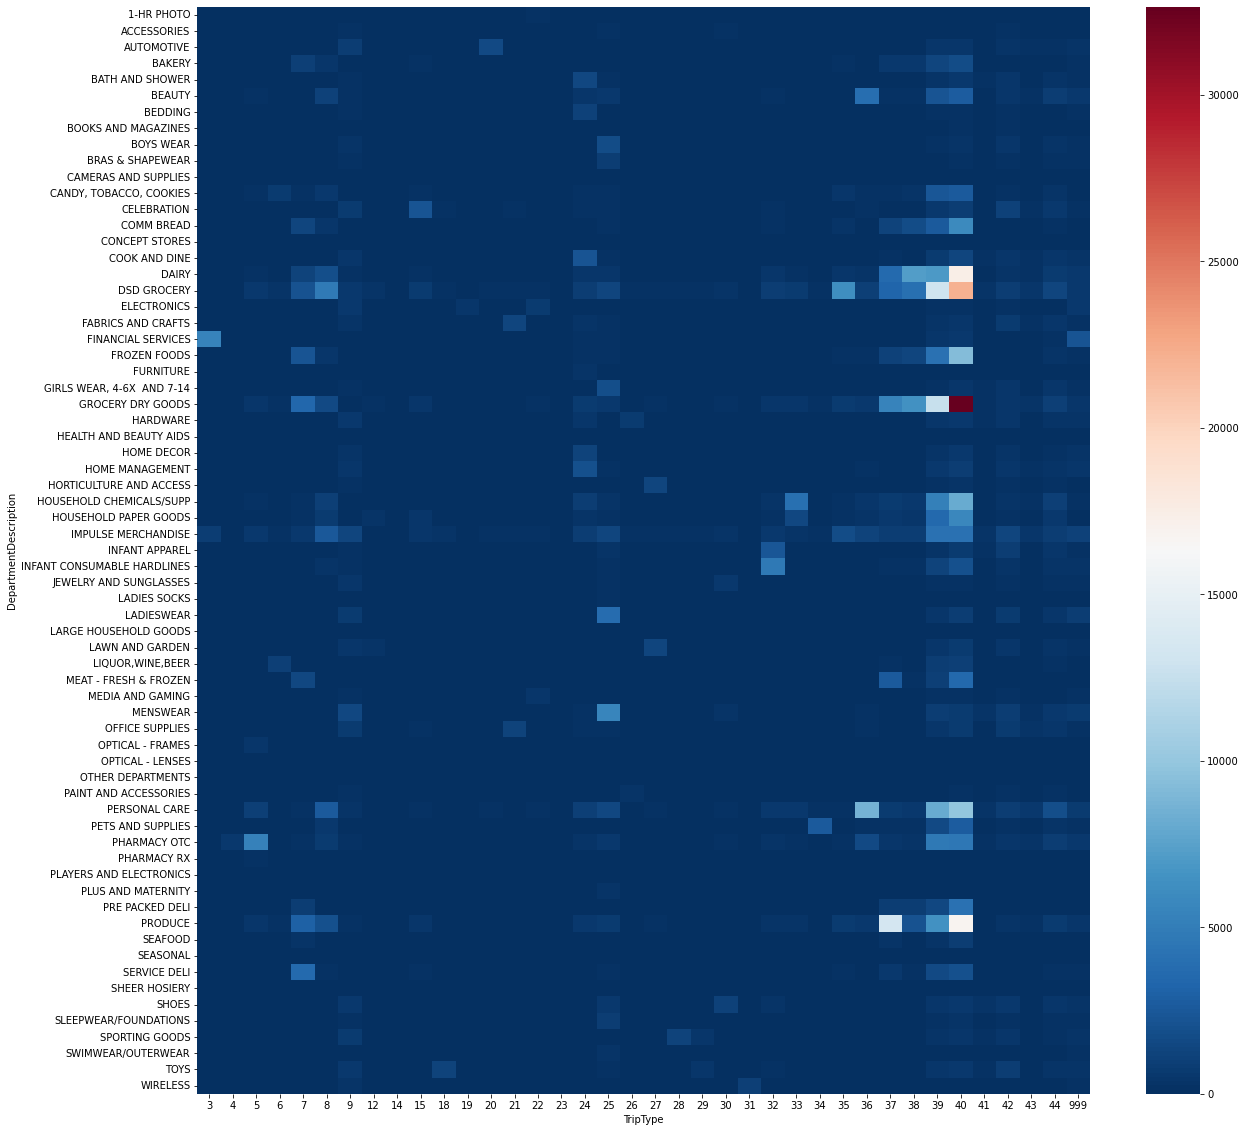

In [8]:
# use .heatmap() to draw a heatmap to visualize the table above and use .subplots() to change the size 
table = pd.crosstab(df_copy.TripType, df_copy.DepartmentDescription)
plt.figure(figsize=(20, 20))
sns.heatmap(table.T,
           cmap="RdBu_r")

## Feature Engineering & Data Preparation

In [9]:
    # 注：此部分需要大量的思考和算法
    # 参考链接：http://kaslemr.github.io/Walmart_Kaggle_Competition/
    
    # Distinguish Return and NumItems purchased
    df_copy.loc[df_copy.ScanCount < 0, 'Return'] = 1
    df_copy.loc[df_copy.Return != 1,   'Return'] = 0
    df_copy.loc[df_copy.ScanCount < 0, 'ScanCount'] = 0
    df_copy = df_copy.rename(columns = {'ScanCount': 'NumItems'})
    df_copy

    
    # Dummy Variable
    dummies = pd.get_dummies(df_copy.DepartmentDescription)
 

    # Calculation - make dummies presenting number of items bought
    data_dummies = dummies.apply(lambda x: x * df_copy.NumItems)
 
    
    # Table Concatenation on calculations
    data = pd.concat([df_copy, data_dummies], axis=1)
    
    
    # Grouby / Find baskets
    grouped = data.groupby('VisitNumber').agg({'TripType':                    np.max, 
                                             'Weekday':                     np.max, 
                                             'NumItems':                    np.sum,
                                             'Return':                      np.max, 
                                             '1-HR PHOTO':                  np.sum,
                                             'ACCESSORIES':                 np.sum, 
                                             'AUTOMOTIVE':                  np.sum, 
                                             'BAKERY':                      np.sum, 
                                             'BATH AND SHOWER':             np.sum, 
                                             'BEAUTY':                      np.sum,
                                             'BEDDING':                     np.sum, 
                                             'BOOKS AND MAGAZINES':         np.sum, 
                                             'BOYS WEAR':                   np.sum, 
                                             'BRAS & SHAPEWEAR':            np.sum,
                                             'CAMERAS AND SUPPLIES':        np.sum, 
                                             'CANDY, TOBACCO, COOKIES':     np.sum, 
                                             'CELEBRATION':                 np.sum,
                                             'COMM BREAD':                  np.sum, 
                                             'CONCEPT STORES':              np.sum, 
                                             'COOK AND DINE':               np.sum, 
                                             'DAIRY':                       np.sum, 
                                             'DSD GROCERY':                 np.sum,
                                             'ELECTRONICS':                 np.sum, 
                                             'FABRICS AND CRAFTS':          np.sum, 
                                             'FINANCIAL SERVICES':          np.sum,
                                             'FROZEN FOODS':                np.sum, 
                                             'FURNITURE':                   np.sum, 
                                             'GIRLS WEAR, 4-6X  AND 7-14':  np.sum,
                                             'GROCERY DRY GOODS':           np.sum, 
                                             'HARDWARE':                    np.sum, 
                                             'HEALTH AND BEAUTY AIDS':      np.sum, 
                                             'HOME DECOR':                  np.sum,
                                             'HOME MANAGEMENT':             np.sum, 
                                             'HORTICULTURE AND ACCESS':     np.sum,
                                             'HOUSEHOLD CHEMICALS/SUPP':    np.sum, 
                                             'HOUSEHOLD PAPER GOODS':       np.sum,
                                             'IMPULSE MERCHANDISE':         np.sum, 
                                             'INFANT APPAREL':              np.sum, 
                                             'INFANT CONSUMABLE HARDLINES': np.sum,
                                             'JEWELRY AND SUNGLASSES':      np.sum, 
                                             'LADIES SOCKS':                np.sum, 
                                             'LADIESWEAR':                  np.sum,
                                             'LARGE HOUSEHOLD GOODS':       np.sum, 
                                             'LAWN AND GARDEN':             np.sum, 
                                             'LIQUOR,WINE,BEER':            np.sum,
                                             'MEAT - FRESH & FROZEN':       np.sum, 
                                             'MEDIA AND GAMING':            np.sum, 
                                             'MENSWEAR':                    np.sum,
                                             'OFFICE SUPPLIES':             np.sum, 
                                             'OPTICAL - FRAMES':            np.sum, 
                                             'OPTICAL - LENSES':            np.sum,
                                             'OTHER DEPARTMENTS':           np.sum, 
                                             'PAINT AND ACCESSORIES':       np.sum, 
                                             'PERSONAL CARE':               np.sum,
                                             'PETS AND SUPPLIES':           np.sum, 
                                             'PHARMACY OTC':                np.sum, 
                                             'PLAYERS AND ELECTRONICS':     np.sum, 
                                             'PLUS AND MATERNITY':          np.sum, 
                                             'PRE PACKED DELI':             np.sum,
                                             'PRODUCE':                     np.sum, 
                                             'SEAFOOD':                     np.sum, 
                                             'SEASONAL':                    np.sum, 
                                             'SERVICE DELI':                np.sum, 
                                             'SHEER HOSIERY':               np.sum,
                                             'SHOES':                       np.sum, 
                                             'SLEEPWEAR/FOUNDATIONS':       np.sum, 
                                             'SPORTING GOODS':              np.sum,
                                             'SWIMWEAR/OUTERWEAR':          np.sum, 
                                             'TOYS':                        np.sum, 
                                             'WIRELESS':                    np.sum
                                        })
    grouped

,TripType,Weekday,NumItems,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,999,Friday,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,30,Friday,2,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,26,Friday,29,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,20,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,8,Friday,3,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
10,8,Friday,3,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191343,25,Sunday,9,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
191344,22,Sunday,5,0.0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
191345,39,Sunday,17,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,5,1,0,0,0,0,0,2,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Trip Type')

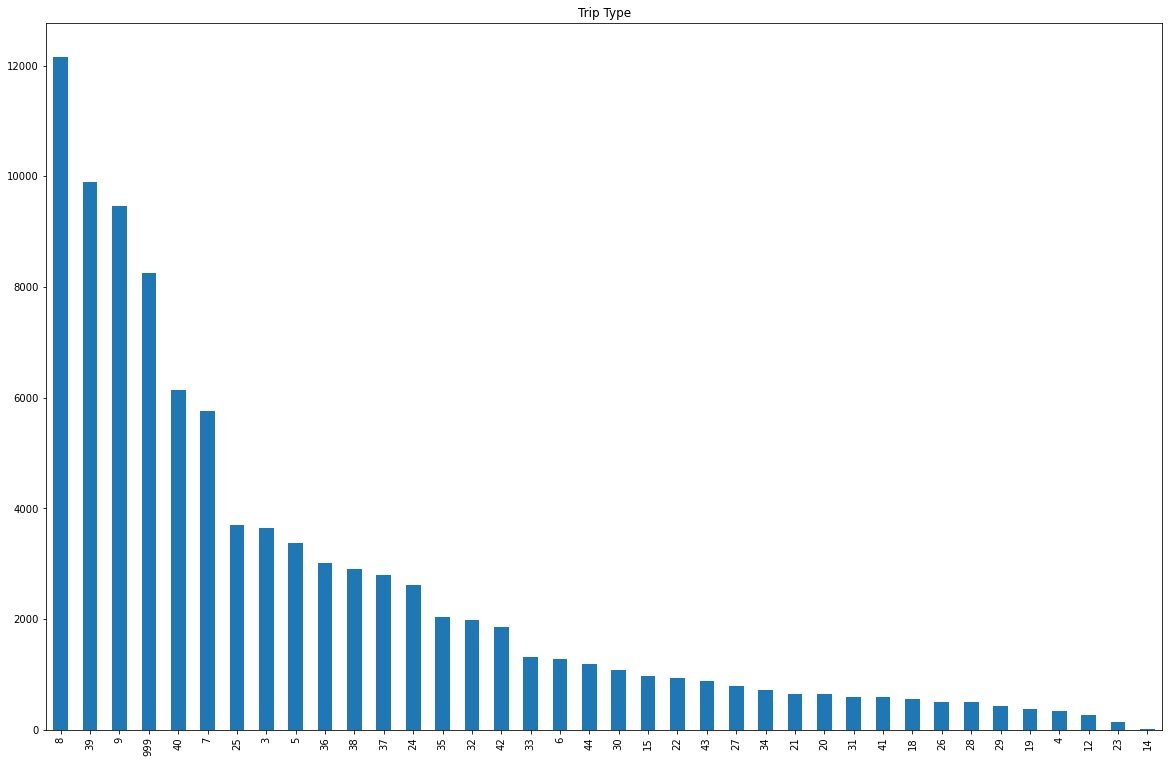

In [10]:
# use .plot() to plot the bar chart for the trip types and use .figure() to change size
trip_count = grouped['TripType'].value_counts()
plt.figure(figsize=(20, 13))
trip_count.plot(kind='bar')
plt.title('Trip Type')

There is a significant class imbalance in terms of predicting object, TripType. So eliminating extremely popular trip types and unpopular trip types to balance classes better.

In [11]:
# use .isin() to select only the following trip types: 25, 3, 5, 36, 38, 37, 24, 35, 32
types=[25,3,5,36,38,37,24,35,32]
df_copy=grouped[grouped.TripType.isin(types)]


# show data .descriptions()
df_copy.describe()

,TripType,NumItems,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
count,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000,26035.000000
mean,24.557519,7.971423,0.052468,0.001383,0.011062,0.020511,0.077473,0.086653,0.237834,0.056002,0.006683,0.076896,0.038640,0.000576,0.086653,0.050010,0.164202,0.000077,0.132591,0.604763,0.852698,0.007644,0.036067,0.262186,0.155982,0.014673,0.084502,0.741118,0.030036,0.000038,0.080238,0.127559,0.010716,0.152986,0.105627,0.374189,0.118341,0.288957,0.015210,0.012022,0.166737,0.002919,0.022086,0.020972,0.135087,0.007029,0.253159,0.045055,0.020165,0.003342,0.000115,0.008527,0.606568,0.041252,0.403150,0.001767,0.012291,0.093528,0.756943,0.015748,0.000192,0.065527,0.005147,0.045477,0.044056,0.018475,0.014865,0.029076,0.002573
std,13.385487,8.526265,0.222973,0.067878,0.152671,0.210452,0.397944,0.811507,1.050052,0.473154,0.109970,0.690925,0.333245,0.032199,0.558498,0.414962,0.657978,0.008765,0.921442,1.686192,2.031273,0.106174,0.410600,0.722989,0.769651,0.191467,0.746303,2.334440,0.258267,0.006198,0.624011,0.718701,0.191227,0.701453,0.488853,0.944383,1.065504,1.449029,0.173975,0.164821,0.876862,0.053951,0.225540,0.216170,0.702772,0.110123,1.032923,0.359794,0.220381,0.071933,0.010734,0.139152,1.838437,0.452885,1.151211,0.053285,0.220002,0.483946,2.168711,0.176557,0.016396,0.357011,0.134264,0.308776,0.383079,0.203687,0.194734,0.258005,0.060353
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [12]:
# use .mean(), .sort_values() and .head() to show the mean of bottom 20 least popular departments
df_copy.mean().sort_values().head(20)

HEALTH AND BEAUTY AIDS     0.000038
CONCEPT STORES             0.000077
OTHER DEPARTMENTS          0.000115
SEASONAL                   0.000192
CAMERAS AND SUPPLIES       0.000576
1-HR PHOTO                 0.001383
PLAYERS AND ELECTRONICS    0.001767
WIRELESS                   0.002573
LARGE HOUSEHOLD GOODS      0.002919
OPTICAL - LENSES           0.003342
SHEER HOSIERY              0.005147
BOOKS AND MAGAZINES        0.006683
MEDIA AND GAMING           0.007029
ELECTRONICS                0.007644
PAINT AND ACCESSORIES      0.008527
HORTICULTURE AND ACCESS    0.010716
ACCESSORIES                0.011062
LADIES SOCKS               0.012022
PLUS AND MATERNITY         0.012291
FURNITURE                  0.014673
dtype: float64

<AxesSubplot:title={'center':'Trip Type'}>

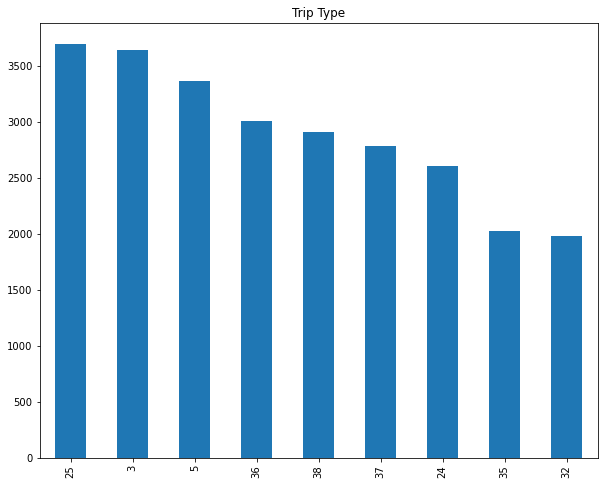

In [13]:
# use .plot() to plot the bar chart for the trip types and use .figure() to change size
trip_count = df_copy['TripType'].value_counts()
plt.figure(figsize=(10, 8))
trip_count.plot(kind='bar', title = "Trip Type")

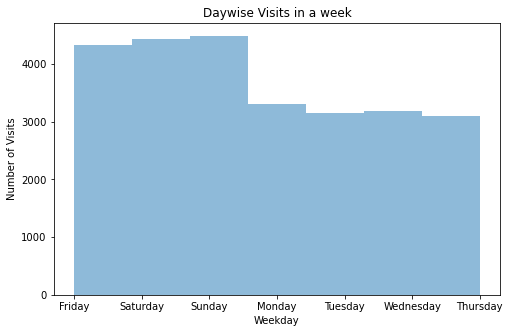

In [14]:
# use .hist() to plot histogram for daywise visits
plt.figure(figsize=(8,5))
plt.hist(df_copy.Weekday, 7, alpha = 0.5)
plt.xlabel('Weekday')
plt.ylabel('Number of Visits')
plt.title('Daywise Visits in a week')
plt.show()

In [15]:
# Use Label Encoder to convert Weedays to computer readable values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_copy['Weekday'] = le.fit_transform(df_copy['Weekday'])
df_copy

,TripType,Weekday,NumItems,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",CELEBRATION,COMM BREAD,CONCEPT STORES,COOK AND DINE,DAIRY,DSD GROCERY,ELECTRONICS,FABRICS AND CRAFTS,FINANCIAL SERVICES,FROZEN FOODS,FURNITURE,"GIRLS WEAR, 4-6X AND 7-14",GROCERY DRY GOODS,HARDWARE,HEALTH AND BEAUTY AIDS,HOME DECOR,HOME MANAGEMENT,HORTICULTURE AND ACCESS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,INFANT APPAREL,INFANT CONSUMABLE HARDLINES,JEWELRY AND SUNGLASSES,LADIES SOCKS,LADIESWEAR,LARGE HOUSEHOLD GOODS,LAWN AND GARDEN,"LIQUOR,WINE,BEER",MEAT - FRESH & FROZEN,MEDIA AND GAMING,MENSWEAR,OFFICE SUPPLIES,OPTICAL - FRAMES,OPTICAL - LENSES,OTHER DEPARTMENTS,PAINT AND ACCESSORIES,PERSONAL CARE,PETS AND SUPPLIES,PHARMACY OTC,PLAYERS AND ELECTRONICS,PLUS AND MATERNITY,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
VisitNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11,35,0,4,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28,25,0,8,0.0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43,38,0,4,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
47,35,0,5,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
63,36,0,5,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191326,38,3,11,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0
191329,24,3,20,0.0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,7,2,0,0,0,1,1,0,0,0,0,0,1,4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
191335,32,3,9,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Train & Test Split

In [16]:
## Train & Test Split# Make a new copy of the data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import sklearn

In [17]:
# Drop TripType (for y) and the least popular 6 depts. Leaving the rest for X
# df=df_copy.drop(['TripType'],axis=1)
df=df_copy.copy()
# Splitting data into training, validation, and testing data
mytrain, mytest = train_test_split(df, test_size = .2, random_state = 999)
# mytrain.TripType = mytrain.TripType.astype(float)
mytrain.Weekday = mytrain.Weekday.astype(float)  
mytrain.NumItems = mytrain.NumItems.astype(float)                         
# mytest.TripType = mytest.TripType.astype(float)
mytest.Weekday = mytest.Weekday.astype(float)  
mytest.NumItems = mytest.NumItems.astype(float) 

In [18]:
# show data shape
print(mytrain.iloc[:, 0:64].shape)
print(mytrain.iloc[:, 0:64].values)
print(mytrain.TripType.shape)

print(mytest.iloc[:, 0:64].shape)
print(mytest.iloc[:, 0:64].values)
print(mytest.TripType.shape)

(20828, 64)
[[24.  2.  1. ...  0.  0.  0.]
 [25.  5. 32. ...  0.  0.  0.]
 [38.  5.  5. ...  0.  0.  0.]
 ...
 [36.  6. 11. ...  0.  0.  0.]
 [38.  2.  4. ...  0.  0.  0.]
 [38.  0. 17. ...  0.  0.  0.]]
(20828,)
(5207, 64)
[[35.  4.  5. ...  0.  0.  0.]
 [35.  0. 15. ...  0.  0.  0.]
 [36.  5. 14. ...  0.  0.  0.]
 ...
 [ 5.  0. 26. ...  0.  0.  0.]
 [ 3.  1.  3. ...  0.  0.  0.]
 [38.  3.  8. ...  0.  0.  0.]]
(5207,)


In [19]:
features = ["Weekday", "NumItems", "Return",  'ACCESSORIES',
       'AUTOMOTIVE', 'BAKERY', 'BATH AND SHOWER', 'BEAUTY', 'BEDDING',
       'BOOKS AND MAGAZINES', 'BOYS WEAR', 'BRAS & SHAPEWEAR',
       'CAMERAS AND SUPPLIES', 'CANDY, TOBACCO, COOKIES', 'CELEBRATION',
       'COMM BREAD', 'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
       'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
       'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
       'GROCERY DRY GOODS', 'HARDWARE', 'HOME DECOR',
       'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
       'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
       'IMPULSE MERCHANDISE', 'INFANT APPAREL', 'INFANT CONSUMABLE HARDLINES',
       'JEWELRY AND SUNGLASSES', 'LADIES SOCKS', 'LADIESWEAR',
       'LARGE HOUSEHOLD GOODS', 'LAWN AND GARDEN', 'LIQUOR,WINE,BEER',
       'MEAT - FRESH & FROZEN', 'MEDIA AND GAMING', 'MENSWEAR',
       'OFFICE SUPPLIES', 'OPTICAL - FRAMES', 'OPTICAL - LENSES',
       'OTHER DEPARTMENTS', 'PAINT AND ACCESSORIES', 'PERSONAL CARE',
       'PETS AND SUPPLIES', 'PHARMACY OTC', 
       'PLAYERS AND ELECTRONICS', 'PLUS AND MATERNITY', 'PRE PACKED DELI',
       'PRODUCE', 'SEAFOOD', 'SEASONAL', 'SERVICE DELI', 'SHEER HOSIERY',
       'SHOES', 'SLEEPWEAR/FOUNDATIONS', 'SPORTING GOODS',
       'SWIMWEAR/OUTERWEAR', 'TOYS', 'WIRELESS']

## Modeling

### Linear Regression

The linear regression model can work well for regression, but fails for classification. Why is that? In case of two classes, you could label one of the classes with 0 and the other with 1 and use linear regression. Technically it works and most linear model programs will spit out weights for you. But there are a few problems with this approach:

线性回归模型可以很好地进行回归，但不能进行分类。这是为什么呢?如果有两个类，可以用0标记其中一个类，用1标记另一个类，并使用线性回归。从技术上讲，它是有效的，大多数线性模型程序会为你提供权重。但这种方法也存在一些问题:

A linear model does not output probabilities, but it treats the classes as numbers (0 and 1) and fits the best hyperplane (for a single feature, it is a line) that minimizes the distances between the points and the hyperplane. So it simply interpolates between the points, and you cannot interpret it as probabilities.

线性模型不输出概率，但它将类视为数字(0和1)，并拟合最佳超平面(对于单个特征，它是一条线)，使点与超平面之间的距离最小化。它只是在点之间插入，不能用概率来解释。

A linear model also extrapolates and gives you values below zero and above one. This is a good sign that there might be a smarter approach to classification.

线性模型还可以进行外推，给出0以下和1以上的值。这是一个好迹象，表明可能存在一种更聪明的分类方法。

Since the predicted outcome is not a probability, but a linear interpolation between points, there is no meaningful threshold at which you can distinguish one class from the other. A good illustration of this issue has been given on [Stackoverflow](https://stats.stackexchange.com/questions/22381/why-not-approach-classification-through-regression).

由于预测的结果不是概率，而是点之间的线性插值，因此不存在有意义的阈值来区分不同的类。关于这个问题的一个很好的例子已经在[Stackoverflow](https://stats.stackexchange.com/questions/22381/why-not-approach-classification-through-regression)上给出。

Linear models do not extend to classification problems with multiple classes. You would have to start labeling the next class with 2, then 3, and so on. The classes might not have any meaningful order, but the linear model would force a weird structure on the relationship between the features and your class predictions. The higher the value of a feature with a positive weight, the more it contributes to the prediction of a class with a higher number, even if classes that happen to get a similar number are not closer than other classes.

线性模型不能扩展到多类的分类问题。您必须开始用2标记下一个类，然后是3，等等。类可能没有任何有意义的顺序，但是线性模型会在特性和类预测之间的关系上强制使用奇怪的结构。具有正权重的特性的值越高，它对具有更高权重的类的预测贡献就越大，即使恰好获得相似权重的类并不比其他类更接近。

### Logistic Regression

逻辑回归（logistic regression）是统计学中的一个经典的分类方法。它的起源主要分为几个阶段，从开始想到logistic这个词，到发现logistic function，再推导出logit function，最后才命名logistic regression。这些过程都是大量的研究者们共同努力发现的，只是在历史的长河中，很多人被渐渐遗忘了。

#### Logistic起源
Logistic起源于对人口数量增长情况的研究，比利时人皮埃尔·弗朗索瓦·费尔许斯特（Pierre François Verhulst）在1838年提出了对人口增长的公式描述。他博士毕业于根特大学的数学系，是个数学教授和人口学家。早在1835年Verhulst的同乡阿道夫·凯特勒（Adolphe Quetelet）发表了一篇关于讨论人口增长的文章，文中认为人口不可能一直是几何（指数）增长，而会被与增长速度平方成比例的一种阻力而影响。这篇论文只有猜想没有数学理论基础，却极大的启发了费尔许斯特。因此在1838年费尔许斯特发表了关于人口数量增长的论文，就是在这篇论文里面他推导出了后来在1845年被定名为logistic equation的公式。文章中谈到一个重要观点，随着时间的增加，一个国家的大小（资源）和这个国家人们的生育能力限制了人口的增长，人口数量会渐渐趋近一个稳定值。费尔许斯特将这个过程用公式给描述出来了，他从人口数量增长的速度公式入手，即人口数量对时间t的导数。他将法国、英国等国十几年的人口实际数据拿来跟这个公式对比之后发现确实拟合的很不错。但他当时并没有更多年的数据，在他过世以后人们总结的300年来的人口增长分布，可以看到非常漂亮地拟合了logisitc分布的累积分布函数走势。

#### Logistic Function
然而在Verhulst发布文章后的几十年内，人们都没有意识到这个工作的重要性，很多人都独立的研究出了这个增长现象，直到1922年一个叫做雷蒙德·珀尔（Raymond Pearl）的人口学家注意到费尔许斯特在1838年就已经提出了这个现象和公式，并在他的文章中也使用了logistic function来称呼它，并且沿用至今。

#### Logit Function
基于珀尔的logistic function，约瑟夫·伯克森（Joseph Berkson）在1944年提出了logit function。

#### Logistic Regression
后来，由英国统计学家大卫·考克斯（David Cox）在1958年提出，逻辑回归假设数据服从伯努利分布，通过极大化相似函数的方法，运用梯度下降来求解参数，来达到将数据二分类的目的。

任何的模型都是有自己的假设，在这个假设下模型才是适用的。逻辑回归的第一个基本假设是假设数据服从伯努利分布。伯努利分布有一个简单的例子是抛硬币，抛中为正面的概率是p，抛中为负面的概率是1-p。

Logistic regression is a technique borrowed by machine learning from the field of statistics. It is the go-to method for binary classification problems (problems with two class values). In this post you will discover the logistic regression algorithm for machine learning.

逻辑回归是机器学习从统计学领域借鉴的一种技术。它是二元分类问题(有两个类值的问题)的首选方法。在这篇文章中，你将发现用于机器学习的逻辑回归算法。

Logistic regression is named for the function used at the core of the method, the logistic function. Logistic regression models the probabilities for classification problems with two possible outcomes. It's an extension of the linear regression model for classification problems.

逻辑回归是以该方法的核心所使用的函数——逻辑回归函数命名的。逻辑回归模型的分类问题的概率有两种可能的结果。它是分类问题线性回归模型的扩展。

The logistic function, also called the sigmoid function was developed by statisticians to describe properties of population growth in ecology, rising quickly and maxing out at the carrying capacity of the environment. It’s an S-shaped curve that can take any real-valued number and map it into a value between 0 and 1, but never exactly at those limits.

logistic函数，也被称为sigmoid函数，是统计学家用来描述生态学中人口增长的特性，增长迅速并达到环境承载力的最大值。它是一条s型曲线，可以取任何实数并将其映射为0到1之间的值，但永远不会恰好在这些极限处。


### Logistic Regression (a.k.a. logit, MaxEnt) classifier

In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to 'ovr', and uses the cross-entropy loss if the 'multi_class' option is set to 'multinomial'. (Currently the 'multinomial' option is supported only by the 'lbfgs', 'sag', 'saga' and 'newton-cg' solvers.)

在多类情况下，如果“multi_class”选项被设置为“ovr”，训练算法使用one-vs-rest (OvR)方案，如果“multi_class”选项被设置为“multinomial”，则使用交叉熵损失。(目前“multinomial”选项只支持“lbfgs”，“sag”，“saga”和“newton-cg”解算器。)

This class implements regularized logistic regression using the 'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. Note that regularization is applied by default. It can handle both dense and sparse input. Use C-ordered arrays or CSR matrices containing 64-bit floats for optimal performance; any other input format will be converted (and copied).

这个类实现正则逻辑回归使用'liblinear'库，'newton-cg'， 'sag'， 'saga'和'lbfgs'求解器。注意，默认情况下应用正则化。它既可以处理密集的输入，也可以处理稀疏的输入。使用c顺序数组或包含64位浮点数的CSR矩阵获得最佳性能;任何其他输入格式都将被转换(和复制)。

The 'newton-cg', 'sag', and 'lbfgs' solvers support only L2 regularization with primal formulation, or no regularization. The 'liblinear' solver supports both L1 and L2 regularization, with a dual formulation only for the L2 penalty. The Elastic-Net regularization is only supported by the 'saga' solver.

“newton-cg”，“sag”和“lbfgs”求解器只支持L2正则化与原始公式，或没有正则化。“线性”求解器支持L1和L2正则化，具有双公式，仅用于L2惩罚。弹性网正规化仅由“saga”求解器支持。

### Supervised Learning - Logistic Regression

In [20]:
%%time
lr = LogisticRegression()
lr.fit(X = np.asarray(mytrain[features]), y = np.asarray(mytrain.TripType))

predictions = lr.predict_proba(np.asarray(mytest[features]))
predictions_notproba = lr.predict(np.asarray(mytest[features]))

print("Log loss Percentage: {}".format(log_loss(mytest.TripType, predictions).round(5)))

print("Accuracy Score: {}".format(sklearn.metrics.accuracy_score(mytest.TripType, predictions_notproba)))


Log loss Percentage: 0.41976
Accuracy Score: 0.8914922220088343
Wall time: 822 ms


#### Accuracy of Logistic Regression

In [21]:
print("The accuracy of Logistic Regression prediction is", 
      '{:.2%}'.format(sklearn.metrics.accuracy_score(mytest.TripType, predictions_notproba)))

The accuracy of Logistic Regression prediction is 89.15%


#### Log Loss of Logistic Regression

__损失函数（loss function）用来估量模型的预测值f(x)与真实值Y的不一致程度__。它是一个非负实值函数,通常使用L(Y, f(x))来表示，__损失函数越小，模型的robustness(可靠性)就越好__。损失函数是经验风险函数的核心部分，也是结构风险函数重要组成部分。模型的结构风险函数包括了 __经验风险项__ 和 __正则项__ ，通常可以表示成如下式子：

![Image](http://www.cda.cn/uploadfile/image/20180826/20180826071141_97639.png)

其中，前面的均值函数表示的是经验风险函数，L代表的是损失函数，后面的Φ是正则化项（regularizer）或者叫惩罚项（penalty term），它可以是L1，也可以是L2，或者其他的正则函数。整个式子表示的意思是找到使目标函数最小时的θ值。

__对数损失函数__
对数损失函数主要在逻辑回归中使用，在逻辑回归的推导中，它假设样本服从伯努利分布（0-1分布），然后求得满足该分布的似然函数，对似然函数的求解方法是通过__最大相似估计__（maximum likelihood estimation，简称MLE），而损失函数一般是每条数据的损失之和，为了把积变为和，就取了对数（取对数是为了方便计算最大相似估计，因为在MLE中，直接求导比较困难，所以通常都是先取对数再求导找极值点）。再加个负号是为了让最大相似值和最小损失对应起来。从损失函数的视角来看，它就成了log损失函数了。

对数损失函数的标准形式如下：

![Image](https://static.tool188.com/static/image/tutorial/loss_function_2.png)

损失函数L(Y, P(Y|X))表达的是样本X在分类Y的情况下，使概率P(Y|X)达到最大值（换言之，就是利用已知的样本分布，找到最有可能（即最大概率）导致这种分布的参数值；或者说什么样的参数才能使我们观测到目前这组数据的概率最大）。因为log函数是单调递增的，所以logP(Y|X)也会达到最大值，因此在前面加上负号之后，最大化P(Y|X)就等价于最小化L了。

逻辑回归最后得到的目标式子如下：

![Image](https://static.tool188.com/static/image/tutorial/loss_function_3.png)

如果是二分类的话，则m值等于2，如果是多分类，m就是相应的类别总个数。

__平方损失函数__
平方损失函数主要用在回归问题上。求解平方损失函数的最小化方法叫做 __最小二乘法__（Ordinary Least Squares）。最小二乘法的基本原则是：__最优拟合曲线应该使得所有点到回归直线的距离和最小。通常用欧式距离进行距离的度量。__

当样本个数为n时，此时的损失函数变为：

![Image](https://static.tool188.com/static/image/tutorial/loss_function_4.png)

In [22]:
print("The log loss of Logistic Regression prediction is", 
      '{:.2}'.format(log_loss(mytest.TripType, predictions).round(5)))

The log loss of Logistic Regression prediction is 0.42


#### Confusion Matrix on Logistic Regression

__混淆矩阵(Confusion Matrix)是分类任务中较常见的评价指标。对于二分类问题，通常将关注的类作为正类，其他类作为负类。__令：

* TP: TRUE POSITIVE 分类器将正类预测为正类的数量
* FN: FALSE NEGATIVE 分类器将正类预测为负类的数量
* FP: FALSE POSITIVE 分类器将负类预测为正类的数量
* TN: TRUE NEGATIVE 分类器将负类预测为负类的数量

基于此，我们可以定义以下指标：

__准确率：Accuracy = (TP+TN)/(P+N) ，预测正确的样本（TP和TN）在所有样本中占的比例。__

在各类样本不均衡时，准确率不能很好表示模型性能，因为会出现大类 dominating 的情况，即大类准确率高，而少数类准确率低。这样情况下，需要对每一类样本单独观察。

__错误率：Error Rate = (FP+FN)/(P+N) ，即被预测错误的样本在所有样本中所占比例。__

__精确率（查准率）： Precision = TP/(TP+FP)，即所有被预测为正例的样本中，多少比例是真的正例。__

__召回率（查全率）： Recall = TP/(TP+FN)，即所有真的正例中，多少比例被模型预测出来了。__

不同的问题中，有的侧重精确率，有的侧重召回率。

对于推荐系统，更侧重于精确率。即推荐的结果中，用户真正感兴趣的比例。因为给用户展示的窗口有限，必须尽可能的给用户展示他真实感兴趣的结果。

对于医学诊断系统，更侧重与召回率。即疾病被发现的比例。因为疾病如果被漏诊，则很可能导致病情恶化。

__精确率和召回率是一对矛盾的度量。一般来说精确率高时召回率往往偏低，而召回率高时精确率往往偏低。__

如果希望将所有的正例都找出来（查全率高），最简单的就是将所有的样本都视为正类，此时有FN=0。此时查准率就偏低（准确性降低）。

如果希望查准率高，则可以只挑选有把握的正例。最简单的就是挑选最有把握的那一个样本。此时有FP=0。此时查全率就偏低（只挑出了一个正例）。

__F1 Score：精确率和召回率的调和平均。F1认为两者同等重要。__



In [23]:
from sklearn.metrics import log_loss,f1_score
print("The f1 score of Logistic Regression prediction is", 
      '{:.2}'.format(f1_score(mytest.TripType, predictions_notproba,average='macro').round(5)))

The f1 score of Logistic Regression prediction is 0.88


#### Classification Report on Logistic Regression

In [24]:
from sklearn.metrics import log_loss,f1_score,classification_report
print(classification_report(mytest.TripType, predictions_notproba))

              precision    recall  f1-score   support

           3       0.98      0.99      0.99       730
           5       0.87      0.92      0.90       653
          24       0.90      0.88      0.89       485
          25       0.94      0.95      0.94       765
          32       0.94      0.88      0.91       388
          35       0.78      0.81      0.80       393
          36       0.88      0.84      0.86       620
          37       0.86      0.88      0.87       557
          38       0.81      0.81      0.81       616

    accuracy                           0.89      5207
   macro avg       0.89      0.88      0.88      5207
weighted avg       0.89      0.89      0.89      5207



__LogisticRegression 主要参数__：

* `penalty : str, ‘l1’ or ‘l2’, default: ‘l2’`
    指定正则化罚项的方式。 ‘newton-cg’, ‘lbfgs’ 和 ‘sag’ 算法只能使用 L2 罚项。

* `tol : float, default: 1e-4`
    算法停止的边界，越大停止越快。

* `C : float, default: 1.0`
    正则化强度的逆（inverse），必须是正的浮点数。
    正如支持向量机，越小的值代表越大的正则化强度。

* `solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default: ‘liblinear’`
    用于问题优化的算法。

__使用方法__(详见：[scikit-learn (sklearn) 官方文档中文版](https://sklearn.apachecn.org/)）

作为优化问题，带 L1 正则的 logistic 回归解决的是如下优化问题：

![Image](https://pic4.zhimg.com/80/v2-7abefd55b7391d1b5dcbce7654d2c3e7_720w.jpg)

类似地，带 L2 罚项的二分类 logistic 回归要最小化以下代价函数（cost function）：

![Image](https://pic2.zhimg.com/80/v2-f566af4b6fa85c6d8a37c363737734d5_720w.jpg)

在`LogisticRegression`类中实现了这些优化算法: “liblinear”， “newton-cg”， “lbfgs”， “sag” 和 “saga”。

“liblinear” 应用了__坐标下降算法（Coordinate Descent, CD）__，并基于 scikit-learn 内附的高性能 C++ 库 LIBLINEAR library 实现。不过 CD 算法训练的模型不是真正意义上的多分类模型，而是基于 “one-vs-rest” 思想分解了这个优化问题，为每个类别都训练了一个二元分类器。因为实现在底层，所以求解器的 LogisticRegression 实例对象表面上看是一个多元分类器。 `sklearn.svm.l1_min_c` 可以计算使用 L1 罚项时 C 的下界，以避免模型为空（即全部特征分量的权重为零）。

* 对于__小数据集__，应该使用 ‘liblinear’，而在__大（高维度）数据集__上使用 ‘sag’ 或 ‘saga’ 会快一些；
* 对于__多分类__问题，__‘liblinear’ 只能处理 one-vs-rest 的情形__，只有 ‘newton-cg’, ‘sag’, ‘saga’ 和 ‘lbfgs’ 可以__计算多项损失__，这些求解器的参数 `multi_class`设为 “multinomial” 即可训练一个真正的多项式 logistic 回归，其预测的概率比默认的 “one-vs-rest” 设定更为准确。
* ‘newton-cg’, ‘lbfgs’ 和 ‘sag’ 算法只能使用 L2 罚项，而 ‘liblinear’ 和 ‘saga’ 使用 L1 罚项。
* “sag” 求解器基于__平均随机梯度下降算法（Stochastic Average Gradient descent）__。在大数据集上的表现更快，大数据集指样本量大且特征数多。
* “saga” 求解器是 “sag” 的一类变体，它支持__非平滑（non-smooth）__的 L1 正则选项 `penalty="l1"` 。因此对于稀疏多项式 logistic 回归 ，往往选用该求解器。
* __“saga” 一般都是最佳的选择__，但出于一些历史遗留原因默认的是 “liblinear” 。
* 请注意 ‘sag’ 和 ‘saga’ 快速收敛的性质仅在具有差不多大小的 feature 数值时得到保证（注：即所有 feature 差不多大）。你可以通过 sklearn.preprocessing 来对你的数据进行预处理。

__分析__：

* C 值代表正则化强度，必须为正值，且越接近零，正则化强度越大，指数级缩放。
* 无论正则化强度怎么变，L2 正则化的系数矩阵稀疏度不变，而 L1 正则化系数矩阵稀疏度和正则化强度呈正相关。
* L2 正则化相比 L1 正则化能保留更多的细节信息，在正则化强度较大是相对表现更好一些。


L1相比于L2，有所不同：
* L1减少的是一个常量，L2减少的是权重的固定比例
* 孰快孰慢取决于权重本身的大小，权重刚大时可能L2快，较小时L1快
* L1使权重稀疏，L2使权重平滑，一句话总结就是：L1会趋向于产生少量的特征，而其他的特征都是0，而L2会选择更多的特征，这些特征都会接近于0
* 实践中L2正则化通常优于L1正则化

#### 基于流水线的工作流和在流水线中集成数据转换以及评估操作

出于性能优化的目的，许多学习算法要求将不同特征的值缩放到相同的范围。这样，我们在使用逻辑回归模型分析数据分析之前需要对数据进行标准化处理。另外，我们也需要尝试用主成分分析（PCA）——使用特征抽取进行降维的技术，将最初的多维数据压缩到一个低维度的空间上。我们可以用流水线将标准化（StandardScaler）、主成分分析（PCA)和逻辑回归串联起来。

### Streamlining Workflows with Pipelines

In [25]:
%%time

# use Pipeline() and .fit() to StandardScaler(), PCA(), and train LogisticRegression() model on X_train and y_train

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe=Pipeline(steps=[
                     ('pca',PCA()),
                     ('SS',StandardScaler()),
                     ('LR',LogisticRegression())
                     ])

# use .fit() to fit and transform the model
pipe.fit(np.asarray(mytrain[features]),np.asarray(mytrain.TripType))

# use .score() to print the test accuracy of the model
pipe.score(np.asarray(mytrain[features]),np.asarray(mytrain.TripType))

Wall time: 881 ms


0.8963414634146342

Pipeline对象采用元组（tuple）的序列作为输入，其中每一个元组中，第一个值为字符串，它可以是任意的标识符，我们通过它来访问流水线中的元素；第二个值为scikit-learn中的一个转换器或者评估器。流水线中包含了scikit-learn中用于数据预处理的类，最后还包括一个评估器。在这段代码中，流水线中有两个预处理环节，分别是用于数据缩放和转换的StandardScaler和PCA，最后还有一个作为评估器的逻辑回归模型。当流水线pipe_lr上执行fit方法时，StandardScaler会在训练数据上执行fit和transform操作，经过转换后的训练数据将传递给下一个对象，再经过fit和transform之后最终给评估器。注意：对于流水线的中间步骤，没有限定数量。

#### 使用学习曲线判定偏差和方差问题

如果一个模型在给定训练数据上构造过于复杂——模型中有太多自由度或者参数——这是模型可能对训练数据过拟合，对未知数据的泛化能力下降。通常情况下，收集更多的训练样本有助于降低模型过拟合程度。但是，实践中，收集更多数据会带来高昂的成本，或者根本不可行。通过将模型的训练以及准确性检验看作是训练数据集大小的函数并绘制图像，我们就可以看出模型面临的方差和偏差问题。

如果模型不能很好地拟合数据，则需要增加模型中参数的数量、降低逻辑回归的正则化程度。如果模型过拟合，我们可以收集更多的训练数据或者降低模型的复杂程度，如增加正则化的参数。对于不适合正则化的模型，也可以通过特征选择来降低特征数量。当然，如果模型本身已经接近于最优，收集更多的训练数据可能反而增加训练数据中的噪声数据，所以增加数据量不一定适用于所有情况。

### Debgugging Algorithms 
#### Learning Curve

Wall time: 0 ns


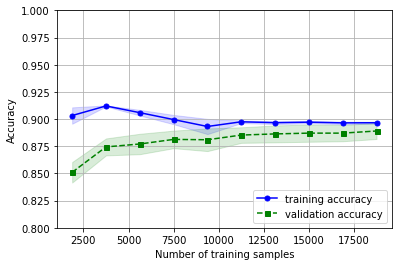

In [26]:
%time
# produce train_sizes, train_scores, and test_scores using .learning_curve()
X_train=np.asarray(mytrain[features])
y_train=np.asarray(mytrain.TripType)
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = Pipeline(steps=[
                    ('pca',PCA()),
                    ('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0, tol=0.000001))])
train_sizes, train_scores, test_scores =\
learning_curve(estimator=pipe_lr,
X=X_train,
y=y_train,
train_sizes=np.linspace(0.1, 1.0, 10),
cv=10,
n_jobs=-1)

# use np.mean() and np.std() to get the mean and standard deviation for train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


# use.plot and .fill_between() to plot the curve
plt.plot(train_sizes, train_mean,
color='blue', marker='o',
markersize=5,
label='training accuracy')

plt.fill_between(train_sizes,
train_mean + train_std,
train_mean - train_std,alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
color='green', linestyle='--',
marker='s', markersize=5,
label='validation accuracy')

plt.fill_between(train_sizes,
test_mean + test_std,
test_mean - test_std,
alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

通过学习曲线图像可见，准确率在89%左右，而且偏差与方差处于相对权衡的位置，这说明这次模型在测试数据集上表现良好。但是，在训练准确率曲线与交叉验证准确率之间，存在着相对较小的差距，这意味着模型对训练数据有轻微的过拟合。

#### 通过验证曲线来判定过拟合与欠拟合

验证曲线是一种通过定位过拟合或欠拟合等问题来帮助提高模型性能的有效工具。验证曲线与学习曲线相似，不过绘制的不是样本大小与训练准确率、测试准确率之间的函数关系，而是准确率与模型参数之间的关系。例如，逻辑回归模型中的正则化参数C。

#### Validation Curve

No handles with labels found to put in legend.


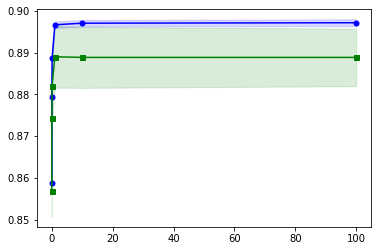

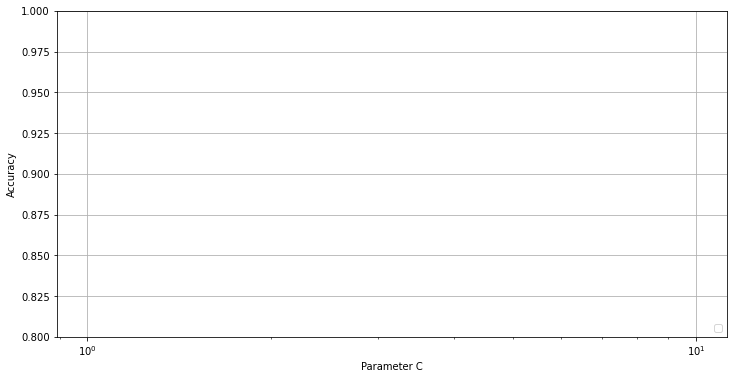

Wall time: 9.51 s


In [27]:
%%time
# use validation_curve() to get train_scores and test_scores
from sklearn.model_selection import validation_curve
param_range =[0.001,0.01,0.1,1.0,10.0,100.0]
train_scores, test_scores = validation_curve(
estimator=pipe_lr,
X=X_train,
y=y_train,
param_name='clf__C',
param_range=param_range,
cv=10,
n_jobs=-1)

# use np.mean() and np.std() to get the mean and standard deviation for train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# use.plot and .fill_between() to plot the validation curve
plt.plot (param_range, train_mean,
color='blue', marker='o',
markersize=5,
label='training accuracy')

plt.fill_between (param_range, train_mean + train_std,
train_mean - train_std, alpha=0.15,
color='blue')

plt.plot (param_range, test_mean,
color='green', linestyle='-',
marker='s', markersize=5,
label='validation accuracy')

plt.fill_between (param_range,
test_mean + test_std,
test_mean - test_std,
alpha=0.15, color='green')

plt.figure(figsize = (12, 6))
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel ('Parameter C')
plt.ylabel ('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()



与learning_curve相似，如果我们使用的是分类算法，则validation_curve函数默认使用K折交叉验证来评价模型的性能。在validation_curve函数内，我们可以指定想要验证的参数。这次的验证参数是C，我们将其标记为`clf__C`，并通过param_range参数来设定它的值域，然后绘制了平均训练准确率、交叉验证准确率以及对应的标准差。

虽然C值之间的准确率差异很小，但是我们可以观察到，如果加大正则化强度（即小C值），会导致模型轻微地欠拟合；如果减小正则化的强度，模型会趋向于过拟合。在这个案例中，最优解在C=10附近。

[模型评估与调优](https://machine-learning-from-scratch.readthedocs.io/zh_CN/latest/%E6%A8%A1%E5%9E%8B%E8%AF%84%E4%BC%B0%E4%B8%8E%E6%A8%A1%E5%9E%8B%E8%B0%83%E4%BC%98.html)

[统计学习笔记6-模型选择和变量选择](https://zhuanlan.zhihu.com/p/75767012)

#### Cross Validation 交叉验证
##### Holdout留出法交叉验证
评估机器学习模型泛化性能的一个经典而且常用的方法。我们将最初的数据集划分为训练集和测试集：前者用于模型的训练，后者用于性能的评估。然而，在典型的机器学习应用中，为了进一步提高模型在预测位置数据上的性能，我们还要对不同的参数设置进行调优和比较。这个过程被称为模型选择（model selection）——针对给定分类问题调整参数以寻找最优解、超参（Hyperparameter）的过程。

在模型选择过程中，如果我们不断重复使用相同的测试数据，则测试数据就会被当作是训练数据的一部分，导致模型更容易过拟合。所以这不是一个好的做法。使用Holdout进行模型选择更好的办法是将数据分为三个部分：训练数据集、验证数据集和测试数据集。训练数据集用于不同模型的拟合，模型在验证数据集上的性能表现作为模型选择的标准。

使用模型训练以及选择阶段没用过的数据作为测试数据集的优势在于：在新数据上评估模型能够获得较小的偏差。但是缺点也很明显：模型性能的评估队训练数据集划分为训练集和验证集的方法很敏感；评价的结果会随着样本的不同而发生变化。

##### K-Fold Cross Validation K折交叉验证（Leave-one-out 留一法， LOO）

在K折交叉验证中，我们不重复地、随机地将训练数据集划分为K个。其中K-1个用于模型的训练，剩余的一个用于测试。重复此过程K次，我们就可以得到K个模型以及对模型性能的更优评价。基于这些独立而且不同的数据自己上得到的性能评价结果，我们可以计算出其平均性能。与Holdout相比，这样得到的结果对数据划分方法的敏感性相对更低。通常情况下，K折交叉验证被用于模型调优的过程。一旦找到了满意的最优解，我们就可以在全部的训练数据上重新训练模型，并使用独立的测试数据集对模型性能做出评价。

K折交叉验证使用了无重复抽样的方法，所以它的优势在于，每次迭代过程中，每个样本只有一次被划入训练集或者测试集的机会，这使得模型性能的评估具有较小的方差。如果训练数据集较小，那就有必要增加K的值，将更多的数据用于模型的训练当中。但是，K值的增加会导致交叉验证算法运行时间延长，而且由于训练集之间高度相似，也会导致结果高方差。当数据集较大时，可以选择较小的K值，以降低模型在不同数据块上进行重复你和性能评估的计算成本，并在平均性能的基础上获得对模型的准确评估。

### Grid Search Cross Validation to select best params

不同的超参数可能会导致我们训练出来不同的模型，也直接会影响到我们模型的表现。那么该如何调整或者说设置这些参数呢？我们就会用到交叉验证。比方我们可以给定几个备选参数（比如网格搜索（Grid Search）），对于每一种参数，我们都进行一次K折交叉验证，然后我们找到损失最小的参数组合，从而达到调参的目的。当然了，这么做的计算量，可想而知，非常非常大。

在机器学习中，有两类参数：通过训练数据学习得到的参数，如逻辑回归中的正则化回归系数；以及学习算法中需要单独进行优化的参数，即调优参数，也叫做超参。
网格搜索是一个常见的调参方法。所谓的栅格搜索其实就是一个暴力搜索。比如某一个模型有五个参数，我们只需要给每个参数五个备选方案，那么所有的参数就有5^5=3125个参数组合，而网格搜索就是把这3125个方案穷举一遍！（代码写出来就是五层for循环……）然后选出损失最小的一组组合，就是我们最后的最优参数。

In [28]:
%time
SVC().get_params().keys()

Wall time: 0 ns


dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

#### Support Vector Machine with Cross Validation

In [ ]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# use Pipeline to StandardScaler() and SVC() the model
pipe_svc = Pipeline([('scl', StandardScaler()),
('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
'clf__kernel': ['linear']},
{'clf__C': param_range,
'clf__gamma': param_range,
'clf__kernel': ['rbf']}]

# use GridSearchCV() to run the pipeline
gs = GridSearchCV(estimator=pipe_svc,
param_grid=param_grid,
scoring='accuracy',
cv=10,
n_jobs=-1)
gs_fit = gs.fit(X_train, y_train)

# use .best_score_ and .best_params_ to show the optimized model

In [ ]:
print("The best performance is:",'{:.2%}'.format(gs_fit.best_score_ ))
print("The best performance is:",'{:.2%}'.format(gs_fit.best_params_))

使用上述代码，我们使用了一个sklearn.model_selection模块下的GridSearchCV对象，用于对支持向量机流水线的训练和调优。我们将GridSearchCV的param_rid参数以字典的方式定义为待调优的参数。对于SVM线性函数来说，我们只需调优正则化参数C；对擅长处理非线性关系的径向基函数（Radial Basis Function, RBF）的SVM核函数来说，我们同时需要调优C和gamma参数。参数gamma定义了单个训练样本的影响大小，值越小影响越大，值越大影响越小。参数gamma可以看作被模型选中作为支持向量的样本的影响半径的倒数。参数C在误分类样本和分界面简单性之间进行权衡。低的C值使分界面平滑，而高的C值通过增加模型自由度以选择更多支持向量来确保所有样本都被正确分类。

在训练集上完成网格搜索之后，通过`best_score_`属性的到最优模型的性能评分，具体参数信息通过`best_params_`属性得到。在本案例中，当`clf_C=0.1`的时候，SVM线性函数可得到具有K折交叉验证且准确率为89.15%的结果。

最后，我们将使用独立的测试数据集，通过GridSearchCV对象的best_estimator_属性对最优模型进行性能评估。

#### Accuracy of Support Vector Machine with Cross Validation

In [ ]:
# use .best_estimator_ and .fit() to find the best model and use .score() to print the best performance
clf = gs.best_estimator_
clf_fit = clf.fit(X_train, y_train)
print("Test Accuracy:", '{:.2%}'.format(clf_fit.score(X_test, y_test)))

#### 通过嵌套交叉验证选择算法

在上一节中，我们看到结合网格搜索进行K折交叉验证，通过超参数值的改动对机器学习模型进行调优，这是一种有效提高机器学习模型性能的方法。如果要在不同机器学习算法中做出选择，则推荐另外一种方法—— __嵌套交叉验证__，估计的真实误差与在测试集上得到的结果几乎没有差距。

嵌套交叉验证分为外部循环和内部循环。在外围循环中，我们将数据划分为训练集和测试集；而在用于模型选择的内部循环中，我们将基于这些训练集使用K折交叉验证。在完成模型的选择之后，测试集用于模型性能的评估。

下面通过一张图来解释嵌套交叉验证的概念。这种情况适用于计算性能要求比较高的大规模数据集。这种类型的嵌套交叉验证也被称作 __5X2交叉验证__。

![Image](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-30-at-6.33.47-PM.png)

#### Algorithm Selections with Nested Cross Validation

In [ ]:
%%time
# use cross_val_score() to find the Cross Validation accuracy in mean +/- standard deviation format
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (
np.mean(scores), np.std(scores)))

In [ ]:
# use cross_val_score() to find the Cross Validation accuracy for each cross validation
print('The cross validation score for each validation is', cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
      )

借助于Scikit-Learn，我们用嵌套交叉验证得到了之前SVC模型通过流水线处理之后的表现结果。代码返回的交叉验证准确率平均值对模型朝参调优的语气之给出了很好的估计，并且使用该值优化过的模型能较为准确地预测未知的数据。

接下来，我们可以使用嵌套交叉验证方法比较SVM模型与简单的决策树分类器/模型。为了简单起见，我们只调优是决策树模型的深度参数。

In [ ]:
%%time

# use GridSearchCV() to run DecisionTreeClassifier() with param_grid set to [{'max_depth': [1,2,3,4,5,6,7,None]}]


# use.fit() to fit the X_train and y_train data


# use .best_score_ and .best_params_ to show the optimized model
print("The best performance is:", '{:.2%}'.format())
print()

# use cross_val_score() to find the Cross Validation accuracy in mean +/- standard deviation format

print('CV accuracy: %.4f +/- %.4f' % ())
print('The cross validation score for each validation is', )

#### Logistic (Lasso) Regression with Cross Validation `LogisticRegressionCV()`

In [58]:
%%time
lr_clf = LogisticRegressionCV(cv=5, random_state=0,penalty="l1",solver="liblinear").fit(X_train, y_train)

Wall time: 3min 55s


#### Accuracy of Logistic (Lasso) Regression with Cross Validation

In [72]:
predictions = lr_clf.predict_proba(np.asarray(mytest[features]))
predictions_notproba = lr_clf.predict(np.asarray(mytest[features]))
print("The accuracy of Logistic Regression L1 CV prediction is", '{:.2%}'.format(accuracy_score(mytest.TripType,predictions_notproba)))
print("The best Lambda for each class is",1/lr_clf.C_)

The accuracy of Logistic Regression L1 CV prediction is 89.19%
The best Lambda for each class is [0.04641589 0.35938137 0.04641589 0.00599484 0.04641589 0.00599484
 0.00077426 0.35938137 0.04641589]


#### Log Loss of Logistic Regression

In [60]:
print("The log loss of Logistic Regression prediction is", 
      '{:.2}'.format(log_loss(mytest.TripType, predictions).round(5)))

The log loss of Logistic Regression prediction is 0.39


#### Confusion Matrix on Logistic (Lasso) Regression with Cross Validation

In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix(mytest.TripType,predictions_notproba)

array([[725,   0,   1,   2,   1,   0,   0,   1,   0],
       [  1, 606,   5,   1,   1,   4,  22,   6,   7],
       [  3,  13, 423,  11,   2,   5,  12,   7,   9],
       [  2,   8,   2, 726,   2,   3,   8,   8,   6],
       [  2,   3,   3,   7, 342,   8,  10,   1,  12],
       [  1,   9,   4,   5,   2, 317,   6,  17,  32],
       [  4,  36,  13,  15,   6,   6, 526,   6,   8],
       [  1,   6,  11,   3,   2,   8,   2, 492,  32],
       [  2,  10,  11,   4,   3,  44,  15,  40, 487]], dtype=int64)

#### Classification Report on Logistic (Lasso) Regression with Cross Validation

In [62]:
print(classification_report(mytest.TripType, predictions_notproba))

              precision    recall  f1-score   support

           3       0.98      0.99      0.99       730
           5       0.88      0.93      0.90       653
          24       0.89      0.87      0.88       485
          25       0.94      0.95      0.94       765
          32       0.95      0.88      0.91       388
          35       0.80      0.81      0.80       393
          36       0.88      0.85      0.86       620
          37       0.85      0.88      0.87       557
          38       0.82      0.79      0.81       616

    accuracy                           0.89      5207
   macro avg       0.89      0.88      0.89      5207
weighted avg       0.89      0.89      0.89      5207



#### Logistic (Ridge) Regression with Cross Validation `LogisticRegressionCV()`

In [63]:
%%time
lr_ridge_clf = LogisticRegressionCV(cv=5, random_state=0,penalty="l2").fit(X_train, y_train)

Wall time: 28.5 s


#### Accuracy of Logistic (Ridge) Regression with Cross Validation

In [71]:
predictions = lr_ridge_clf.predict_proba(np.asarray(mytest[features]))
predictions_notproba = lr_ridge_clf.predict(np.asarray(mytest[features]))
print("The accuracy of Logistic Regression L2 CV prediction is", '{:.2%}'.format(accuracy_score(mytest.TripType,predictions_notproba)))
print("The best Lambda for each class is",1/lr_ridge_clf.C_)

The accuracy of Logistic Regression L2 CV prediction is 89.07%
The best Lambda for each class is [0.35938137 0.35938137 0.35938137 0.35938137 0.35938137 0.35938137
 0.35938137 0.35938137 0.35938137]


#### Log Loss of Logistic Regression

In [65]:
print("The log loss of Logistic Regression prediction is", '{:.2}'.format(log_loss(mytest.TripType, predictions).round(5)))

The log loss of Logistic Regression prediction is 0.42


#### Confusion Matrix on Logistic (Ridge) Regression with Cross Validation

In [66]:
confusion_matrix(mytest.TripType,predictions_notproba)

array([[725,   0,   1,   2,   1,   0,   0,   1,   0],
       [  1, 604,   6,   1,   1,   6,  22,   7,   5],
       [  3,  12, 423,  10,   1,   7,  11,   8,  10],
       [  3,   8,   1, 723,   3,   4,   6,  10,   7],
       [  1,   5,   3,   7, 338,   8,   9,   2,  15],
       [  0,   8,   3,   4,   2, 322,   6,  14,  34],
       [  3,  41,  15,  15,   6,   6, 519,   6,   9],
       [  1,   7,  11,   2,   2,  12,   4, 487,  31],
       [  1,   8,  10,   4,   4,  45,  15,  32, 497]], dtype=int64)

#### Classification Report on Logistic (Ridge) Regression with Cross Validation

In [67]:
print(classification_report(mytest.TripType, predictions_notproba))

              precision    recall  f1-score   support

           3       0.98      0.99      0.99       730
           5       0.87      0.92      0.90       653
          24       0.89      0.87      0.88       485
          25       0.94      0.95      0.94       765
          32       0.94      0.87      0.91       388
          35       0.79      0.82      0.80       393
          36       0.88      0.84      0.86       620
          37       0.86      0.87      0.87       557
          38       0.82      0.81      0.81       616

    accuracy                           0.89      5207
   macro avg       0.89      0.88      0.88      5207
weighted avg       0.89      0.89      0.89      5207



#### Penalty and Sparsity in Logistic Regression 逻辑回归中的惩罚与稀疏性

比较不同的C值使用L1、L2和弹性网惩罚时解的稀疏性(零系数的百分比)，可以看出C值越大，模型的自由度越大。相反，C的值越小，对模型的约束就越大。在L1惩罚的情况下，这会导致更稀疏的解决方案。正如预期的那样，弹性网惩罚稀疏性介于L1和L2之间。

__Sparsity稀疏表达__

用较少的基本信号的线性组合来表达大部分或者全部的原始信号。传统机器学习的算法，先降维，再学习，比如PCA – a complete set of basis vectors. 然后对原始数据进行还原，剔除无关和非必要项，实现降维，然后展开机器学习。

近些年的算法开始流行稀疏表达（Sparse Representation）—— an over-complete set of basis vectors. 通过学习到超完备的特征，然后找出最优组合。这个过程中，基本向量的数量甚至可能超过输入向量数量。

举例：用两个数字组分别做算术，算出123.456这个目标数字
* A: 100，10，1
* B: 100, 50, 10, 1, 0.5, 0.1, 0.03, 0.01, 0.001

A组误差0.456； B组误差0

虽然B组存在诸多系数为零的特征量，但是它得以让我们实现目标，因此sparse feature的存在是有必要的。

__Sparsity稀疏表达的意义__:
* Sparse表示为模型内的参数中，只有很少的几个非零元素，或者很少的几个远大于零的元素。
* 降低数据维度（降维），稀疏表达后的特征向量在各个维度之间的依赖性变低，更为独立
* 从智能角度看，稀疏表达的目的在于帮助找出隐藏在数据背后的解释因子

__如何保证稀疏性？__

在损失函数中加入正则项，以惩罚模型参数值，使之趋近于零。（惩罚：使参数值趋近于零）

我们可以发现较大的C值给予模型更大的自由性，较小的C值对模型有较大的约束。在L1惩罚项的情况下，会有更稀疏的结果。

下方是模型的输出结果，可以看到具体的稀疏百分比：

__使用方法__(详见：[L1 Penalty and Sparsity in Logistic Regression](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html)）

LogisticRegression(C=1, penalty='l1', solver='saga', tol=0.01)
C=1.00
Sparsity with L1 penalty:                10.08%
Sparsity with Elastic-Net penalty:       7.68%
Sparsity with L2 penalty:                3.52%
Score with L1 penalty:                   0.86
Score with Elastic-Net penalty:          0.86
Score with L2 penalty:                   0.86
LogisticRegression(C=0.1, penalty='l1', solver='saga', tol=0.01)
C=0.10
Sparsity with L1 penalty:                34.72%
Sparsity with Elastic-Net penalty:       23.52%
Sparsity with L2 penalty:                3.52%
Score with L1 penalty:                   0.85
Score with Elastic-Net penalty:          0.86
Score with L2 penalty:                   0.86
LogisticRegression(C=0.01, penalty='l1', solver='saga', tol=0.01)
C=0.01
Sparsity with L1 penalty:                75.52%
Sparsity with Elastic-Net penalty:       61.60%
Sparsity with L2 penalty:                3.52%
Score with L1 penalty:                   0.85
Score with Elastic-Net penalty:    

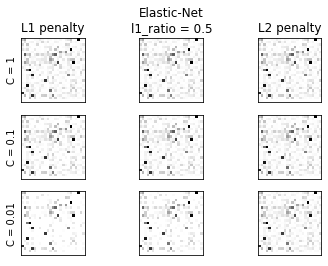

Wall time: 28 s


In [78]:
%%time

X, y = X_train,y_train


l1_ratio = 0.5  # L1 weight in the Elastic-Net regularization

fig, axes = plt.subplots(3, 3)

# Set regularization parameter
for i, (C, axes_row) in enumerate(zip((1, 0.1, 0.01), axes)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty="l1", tol=0.01, solver="saga")
    print(clf_l1_LR)
    clf_l2_LR = LogisticRegression(C=C, penalty="l2", tol=0.01, solver="saga")
    clf_en_LR = LogisticRegression(
        C=C, penalty="elasticnet", solver="saga", l1_ratio=l1_ratio, tol=0.01
    )
    clf_l1_LR.fit(X, y)
    clf_l2_LR.fit(X, y)
    clf_en_LR.fit(X, y)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()
    coef_en_LR = clf_en_LR.coef_.ravel()
    
    coef_l1_LR=np.append(coef_l1_LR,[0]*22)
    coef_l2_LR=np.append(coef_l2_LR,[0]*22)
    coef_en_LR=np.append(coef_en_LR,[0]*22)
    

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
    sparsity_en_LR = np.mean(coef_en_LR == 0) * 100

    print("C=%.2f" % C)
    print("{:<40} {:.2f}%".format("Sparsity with L1 penalty:", sparsity_l1_LR))
    print("{:<40} {:.2f}%".format("Sparsity with Elastic-Net penalty:", sparsity_en_LR))
    print("{:<40} {:.2f}%".format("Sparsity with L2 penalty:", sparsity_l2_LR))
    print("{:<40} {:.2f}".format("Score with L1 penalty:", clf_l1_LR.score(X, y)))
    print(
        "{:<40} {:.2f}".format("Score with Elastic-Net penalty:", clf_en_LR.score(X, y))
    )
    print("{:<40} {:.2f}".format("Score with L2 penalty:", clf_l2_LR.score(X, y)))

    if i == 0:
        axes_row[0].set_title("L1 penalty")
        axes_row[1].set_title("Elastic-Net\nl1_ratio = %s" % l1_ratio)
        axes_row[2].set_title("L2 penalty")

    for ax, coefs in zip(axes_row, [coef_l1_LR, coef_en_LR, coef_l2_LR]):
        ax.imshow(
            np.abs(coefs.reshape(25, 25)),
            interpolation="nearest",
            cmap="binary",
            vmax=1,
            vmin=0,
        )
        ax.set_xticks(())
        ax.set_yticks(())

    axes_row[0].set_ylabel("C = %s" % C)

plt.show()

#### 逻辑回归优缺点
逻辑回归作为工业界大量使用的算法，有很多优点，同时也有一些不足。

##### 逻辑回归的优点
逻辑回归有如下几个优点：
* 形式简单，模型的可解释性非常好。从特征的权重可以看到不同的特征对最后结果的影响，某个特征的权重值比较高，那么这个特征最后对结果的影响会比较大。
* 模型效果不错。如果特征工程做的好，效果不会太差.
* 训练速度较快。分类的时候，计算量仅仅只和特征的数目相关。并且逻辑回归的分布式优化Stochastic Gradient Descent(SGD)发展比较成熟，训练的速度可以通过堆机器进一步提高，这样我们可以在短时间内迭代好几个版本的模型。
* 资源占用小，尤其是内存。因为只需要存储各个维度的特征值。
* 方便输出结果调整。逻辑回归可以很方便的得到最后的分类结果，因为输出的是每个样本的概率分数，我们可以很容易的对这些概率分数进行cutoff，也就是划分阈值（大于某个阈值的是一类，小于某个阈值的是一类）。

##### 逻辑回归的缺点
逻辑回归有很多优点，同样也如下不足：
* 准确率并不是很高。因为形式非常的简单（非常类似线性模型），很难去拟合数据的真实分布。
* 很难处理数据不平衡的问题。举个例子，如果我们对于一个正负样本非常不平衡的问题，比如正负样本比为10000:1。我们把所有样本都预测为正也能使损失函数的值比较小。但是作为一个分类器，它对正负样本的区分能力不会很好。
* 处理非线性数据较麻烦。逻辑回归在不引入其他方法的情况下，只能处理线性可分的数据，或者进一步说，处理二分类的问题。
* 逻辑回归本身无法筛选特征。有时候，我们会用Gradient Boosted Decision Trees (GBDT) 来筛选特征，然后再上逻辑回归。

#### 逻辑回归与支持向量机的关系
##### 相同点：
* 都是有监督分类方法，判别模型(直接估计y=f(x)或P(y|x)) 。
* 都是线性分类方法(指不用核函数的情况)。

##### 不同点:
* 损失函数不同。逻辑回归是交叉熵;支持向量机是铰链损失(Hinge loss)，最大化函数间隔。
* 逻辑回归决策考虑所有样本点，支持向量机决策仅仅取决于支持向量。
* 逻辑回归受数据分布影响，尤其是样本不均衡时影响大，要先做平衡，支持向量机不直接依赖于分布。
* 逻辑回归可以产生概率，支持向量机不能。
* 逻辑回归是经验风险最小化，需要另外加正则，支持向量机自带结构风险最小化不需要加正则项。
* 逻辑回归每两个点之间都要做内积，而支持向量机只需要计算样本和支持向量的内积，计算量更小。

### 面试常见问题：

#### 在逻辑回归模型中，损失函数为什么是对数损失函数(交叉熵 Cross Entropy)，而不是均方误差（Mean Square Error）?
逻辑回归模型预估的是样本属于某个分类的概率，其损失函数(Cost Function)可以像线型回归那样，以均方差来表示；也可以用对数、概率等方法。损失函数本质上是衡量”模型预估值“到“实际值”的距离，选取好的“距离”单位，可以让模型更加准确。线性回归用的就是使用的平方损失函数。相比之下逻辑回归选择使用log距离有以下原因：第一，平方损失函数函数并非是凸的函数，会得到多个局部最优解，好像可以使用海森矩阵的正定型性进行证明，还有待深究。而用对数似然函数得到高阶连续可导凸函数，可以得到最优解。第二，根据参数的初始化，导数值可能很小(想象一下sigmoid函数在输入较大时的梯度)而导致收敛变慢，而训练途中也可能因为该值过小而提早终止训练。第三，是因为对数损失函数更新起来很快，因为只和x，y有关，和sigmoid本身的梯度无关。logloss的梯度如下，当模型输出概率偏离于真实概率时，梯度较大，加快训练速度，当拟合值接近于真实概率时训练速度变缓慢，没有MSE的问题。以下这篇文章讲将两种损失函数进行了对比，讲解比较细致，可以参考参考文献3。

#### 逻辑回归在训练的过程当中，如果有很多的特征高度相关或者说有一个特征重复了100遍，会造成怎样的影响？ 
如果在损失函数最终收敛的情况下，其实就算有很多特征高度相关也不会影响分类器的效果。但是对特征本身来说的话，假设只有一个特征，在不考虑采样的情况下，你现在将它重复100遍。训练完以后，数据还是这么多，但是这个特征本身重复了100遍，实质上将原来的特征分成了100份，每一个特征都是原来特征权重值的百分之一。如果在随机采样的情况下，其实训练收敛完以后，还是可以认为这100个特征和原来那一个特征扮演的效果一样，只是可能中间很多特征的值正负相消了。

#### 为什么我们还是会在训练的过程当中将高度相关的特征去掉？ 
去掉高度相关的特征会让模型的可解释性更好。另外，可以大大提高训练的速度。如果模型当中有很多特征高度相关的话，就算损失函数本身收敛了，但实际上参数是没有收敛的，这样会拉低训练的速度。其次是特征多了，本身就会增大训练的时间。